In [1]:
# n - number of data points
# d - dimensionality
# alpha - number of corrupted points, change the fraction within expression
# mu, sigma - parameters for any gaussian being used, feel free to change
import numpy as np
import matplotlib.pyplot as plt
from irls_lib import *
import pickle
import statsmodels.api as sm
import time
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
store_result=False
cross_validation=False

n = 10000
d = 100
alpha  = 0.2

n_corr  = int(alpha*n)

Idx= np.random.permutation(n)
corrIdx= Idx[0:n_corr]
cleanIdx=Idx[n_corr:n]

mu = 0
sigma = 1
X = np.random.normal(mu, sigma, (n, d))

w_star= np.random.normal(0,1, (d, 1))
w_star = w_star / np.linalg.norm(w_star)
w_adv= np.random.normal(0,1, (d, 1))

y=np.zeros(shape=(n,1))
y[cleanIdx] = np.dot(X[cleanIdx,:], w_star)
y[corrIdx] = np.dot(X[corrIdx,:], w_adv)

noise_sigma=0.1
y=y+np.random.normal(0,noise_sigma,(n,1))

In [3]:
#------------APIS-------------#

if cross_validation:
    alpha_range = np.linspace( 0.01, 0.2, 20 )
    param_grid = dict( alpha = alpha_range )
    cv = ShuffleSplit( n_splits = 5, test_size = 0.3, random_state = 42 )
    grid = GridSearchCV( APIS( w_init = w_adv, w_star = w_star ), param_grid=param_grid, cv = cv, refit = False )
    grid.fit( X, y )
    best = grid.best_params_
    print("The best parameters for APIS are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    apis = APIS(alpha= best["alpha"], w_init = w_adv, w_star = w_star )
else:
    apis =APIS(alpha=alpha, w_init = w_adv, w_star = w_star )

apis.fit( X, y )
l2_altproj = apis.l2
clock_altproj = apis.clock

#------------STIR-------------#

if cross_validation:
    eta_range = np.linspace( 1.01, 3.01, 21 )
    alpha_range = np.linspace( alpha, alpha, 1 )
    # STIR does not itself use alpha as a hyperparameter in the algorithm
    # but does need it to perform cross-validation since the validation sets
    # are also corrupted. To avoid an unfair comparison, We offer STIR a
    # handicap by giving it the true value of alpha
    param_grid = dict( eta = eta_range, alpha = alpha_range )
    cv = ShuffleSplit( n_splits = 5, test_size = 0.3, random_state = 42 )
    grid = GridSearchCV( STIR( w_init = w_adv, w_star = w_star ), param_grid=param_grid, cv = cv, refit = False )
    grid.fit( X, y )
    best = grid.best_params_
    print("The best parameters for STIR are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    stir = STIR( eta = best["eta"], alpha = best["alpha"], M_init = np.power(10, 1), w_init = w_adv, w_star = w_star )
else:
    stir = STIR( eta = 2, alpha = alpha, M_init = np.power(10, 1), w_init = w_adv, w_star = w_star )

stir.fit( X, y )
l2_stir = stir.l2
clock_stir = stir.clock

#------------TORRENT----------#
if cross_validation:
    alpha_range = np.linspace( 0.05, 0.2, 20 )
    param_grid = dict( alpha = alpha_range )
    cv = ShuffleSplit( n_splits = 5, test_size = 0.3, random_state = 42 )
    grid = GridSearchCV( TORRENT( w_init = w_adv, w_star = w_star ), param_grid=param_grid, cv = cv, refit = False )
    grid.fit( X, y )
    best = grid.best_params_
    print("The best parameters for TORRENT are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    torrent = TORRENT( alpha = best["alpha"], w_init = w_adv, w_star = w_star )
else:
    torrent = TORRENT( alpha = alpha, w_init = w_adv, w_star = w_star )
    
torrent.fit( X, y )
l2_torrent = torrent.l2
clock_torrent = torrent.clock


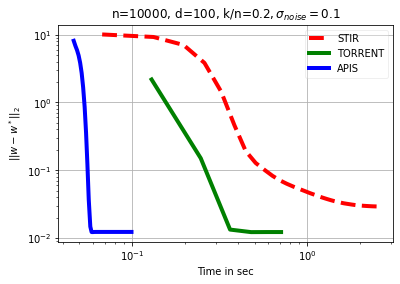

In [4]:
n = 10000
d = 100
alpha  = 0.2
noise_sigma=0.1
file_name='n='+str(n)+' d='+str(d)+' alpha='+str(alpha)+' noise_sigma='+str(noise_sigma)




import matplotlib.pyplot as plt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.figure()
plt.xlabel('Time in sec')
plt.ylabel('$||w-w^*||_2$')

plt.plot(clock_stir, l2_stir, label = 'STIR', ls='--',color='red',linewidth=4)
plt.plot(clock_torrent, l2_torrent, label = 'TORRENT',color='green',linewidth=4)
plt.plot(clock_altproj, l2_altproj, label = 'APIS', color='blue',linewidth=4)

plt.legend(loc='upper right',prop = {'size': 10}, framealpha=0.3)
plt.grid()
plt.title('n='+str(n)+', d='+str(d)+', k/n='+str(alpha)+r'$, \sigma_{noise}=$'+str(noise_sigma))
plt.xscale('log')
plt.yscale('log')
#plt.savefig('plot/'+'l2_vs_time_'+file_name+'.pdf', dpi=300)